# Multi-Area Time Series Download - S2E84

Advanced example showing time series image download across multiple areas using Element84 data.

**Demonstrates:**
- Downloading multiple images per area (time series)
- Processing multiple areas from GeoJSON
- Creating 3x3 visualization grid (3 areas × 3 images)
- Proper image scaling for Element84 data (different from MPC)

Author: Peter Kongstad

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

from sat_data_acquisition import SatDataClient, ProcessingParams, SaveParams, configure_logging
from sat_data_acquisition.processing import save_data
from sat_data_acquisition.config.settings import SatDataSettings

In [9]:
# Configure logging
configure_logging(verbose=False)

## Load Multiple Areas from GeoJSON

Load example areas (Copenhagen, London, Paris) from GeoJSON file.

In [10]:
# Load areas from GeoJSON
gdf = gpd.read_file('../../data/geojson/example_areas.geojson')

print(f"Loaded {len(gdf)} areas:")
for idx, row in gdf.iterrows():
    print(f"  - {row['name']}")
    
# Show first area geometry
print(f"\nFirst area ({gdf.iloc[0]['name']}):")
print(f"  Bounds: {gdf.iloc[0].geometry.bounds}")
print(f"  Area: ~{(0.04 * 111 * 0.03 * 111):.1f} km²")

Loaded 3 areas:
  - copenhagen
  - london
  - seattle

First area (copenhagen):
  Bounds: (12.548, 55.661, 12.588, 55.691)
  Area: ~14.8 km²


## Configure Processing Parameters

Set up parameters for Sentinel-2 imagery from Element84.

In [11]:
# Initialize client
client = SatDataClient()
settings = SatDataSettings()

# Configure processing parameters
processing_params = ProcessingParams(
    satellite='S2E84',  # Element84
    bands=['red', 'green', 'blue'],  # RGB bands for visualization
    search_method='date',
    start_date='2024-06-01',  # Summer imagery (less clouds)
    end_date='2024-08-31',
    cloud_coverage=20,  # Max 20% cloud coverage
    groupby='solar_day',  # Merge overlapping tiles from same day
)

print("Processing parameters configured:")
print(f"  Satellite: {processing_params.satellite}")
print(f"  Bands: {processing_params.bands}")
print(f"  Date range: {processing_params.start_date} to {processing_params.end_date}")
print(f"  Max cloud coverage: {processing_params.cloud_coverage}%")

Processing parameters configured:
  Satellite: S2E84
  Bands: ['red', 'green', 'blue']
  Date range: 2024-06-01 to 2024-08-31
  Max cloud coverage: 20%


## Download Images for Multiple Areas

Download time series imagery for each area (limit to 3 areas × 3 images for visualization).

In [12]:
# Download for multiple areas
max_areas = 3  # Limit to 3 areas for demo
max_images_per_area = 3  # Get up to 3 images per area

results = []

for area_idx, area_row in gdf.head(max_areas).iterrows():
    area_name = area_row['name']
    geometry = area_row['geometry']  # Keep as shapely geometry
    
    print(f"\n{'='*60}")
    print(f"Processing: {area_name}")
    print(f"{'='*60}")
    
    dataset = client.search_and_create_image(
        geometry=geometry,
        processing_params=processing_params,
    )
    
    n_images = len(dataset.time)
    print(f"✓ Downloaded {n_images} images for {area_name}")
    print(f"  Image shape: {dict(dataset.sizes)}")
    
    # Store results
    results.append({
        'area_name': area_name,
        'dataset': dataset,
        'n_images': n_images
    })

print(f"\n{'='*60}")
print(f"Download complete!")
print(f"Total areas processed: {len(results)}")
print(f"{'='*60}")


Processing: copenhagen
✓ Downloaded 3 images for copenhagen
  Image shape: {'y': 343, 'x': 263, 'time': 3}

Processing: london
✓ Downloaded 5 images for london
  Image shape: {'y': 344, 'x': 291, 'time': 5}

Processing: seattle
✓ Downloaded 14 images for seattle
  Image shape: {'y': 336, 'x': 303, 'time': 14}

Download complete!
Total areas processed: 3


## Visualization Helper Functions

Clean functions for RGB processing and plotting (E84 uses simpler scaling).

In [13]:
def process_rgb_for_display(image_slice, scale=3000):
    """
    Process RGB bands for display with Element84 data.
    
    E84 data has better native dynamic range, so simple scaling works well.
    Note: E84 returns data with native band names (B04, B03, B02).
    
    Args:
        image_slice: xarray Dataset with B04, B03, B02 bands (E84 native names)
        scale: Scale factor for normalization (default 3000 for E84)
        
    Returns:
        numpy array (H, W, 3) with values in [0, 1]
    """
    # Stack RGB bands - E84 uses native Sentinel-2 names
    rgb = np.dstack([
        image_slice['red'].values,  # Red
        image_slice['green'].values,  # Green
        image_slice['blue'].values   # Blue
    ])
    
    # Simple scaling and clipping
    rgb_scaled = np.clip(rgb / scale, 0, 1)
    
    return rgb_scaled


def plot_image(ax, rgb, title):
    """
    Plot a single RGB image on given axes.
    
    Args:
        ax: matplotlib axes object
        rgb: RGB array (H, W, 3) with values in [0, 1]
        title: Title string for the plot
    """
    ax.imshow(rgb)
    ax.set_title(title, fontsize=10, pad=5)
    ax.axis('off')

## Create 3×3 Visualization Grid

Display 3 areas × 3 images in a grid layout.

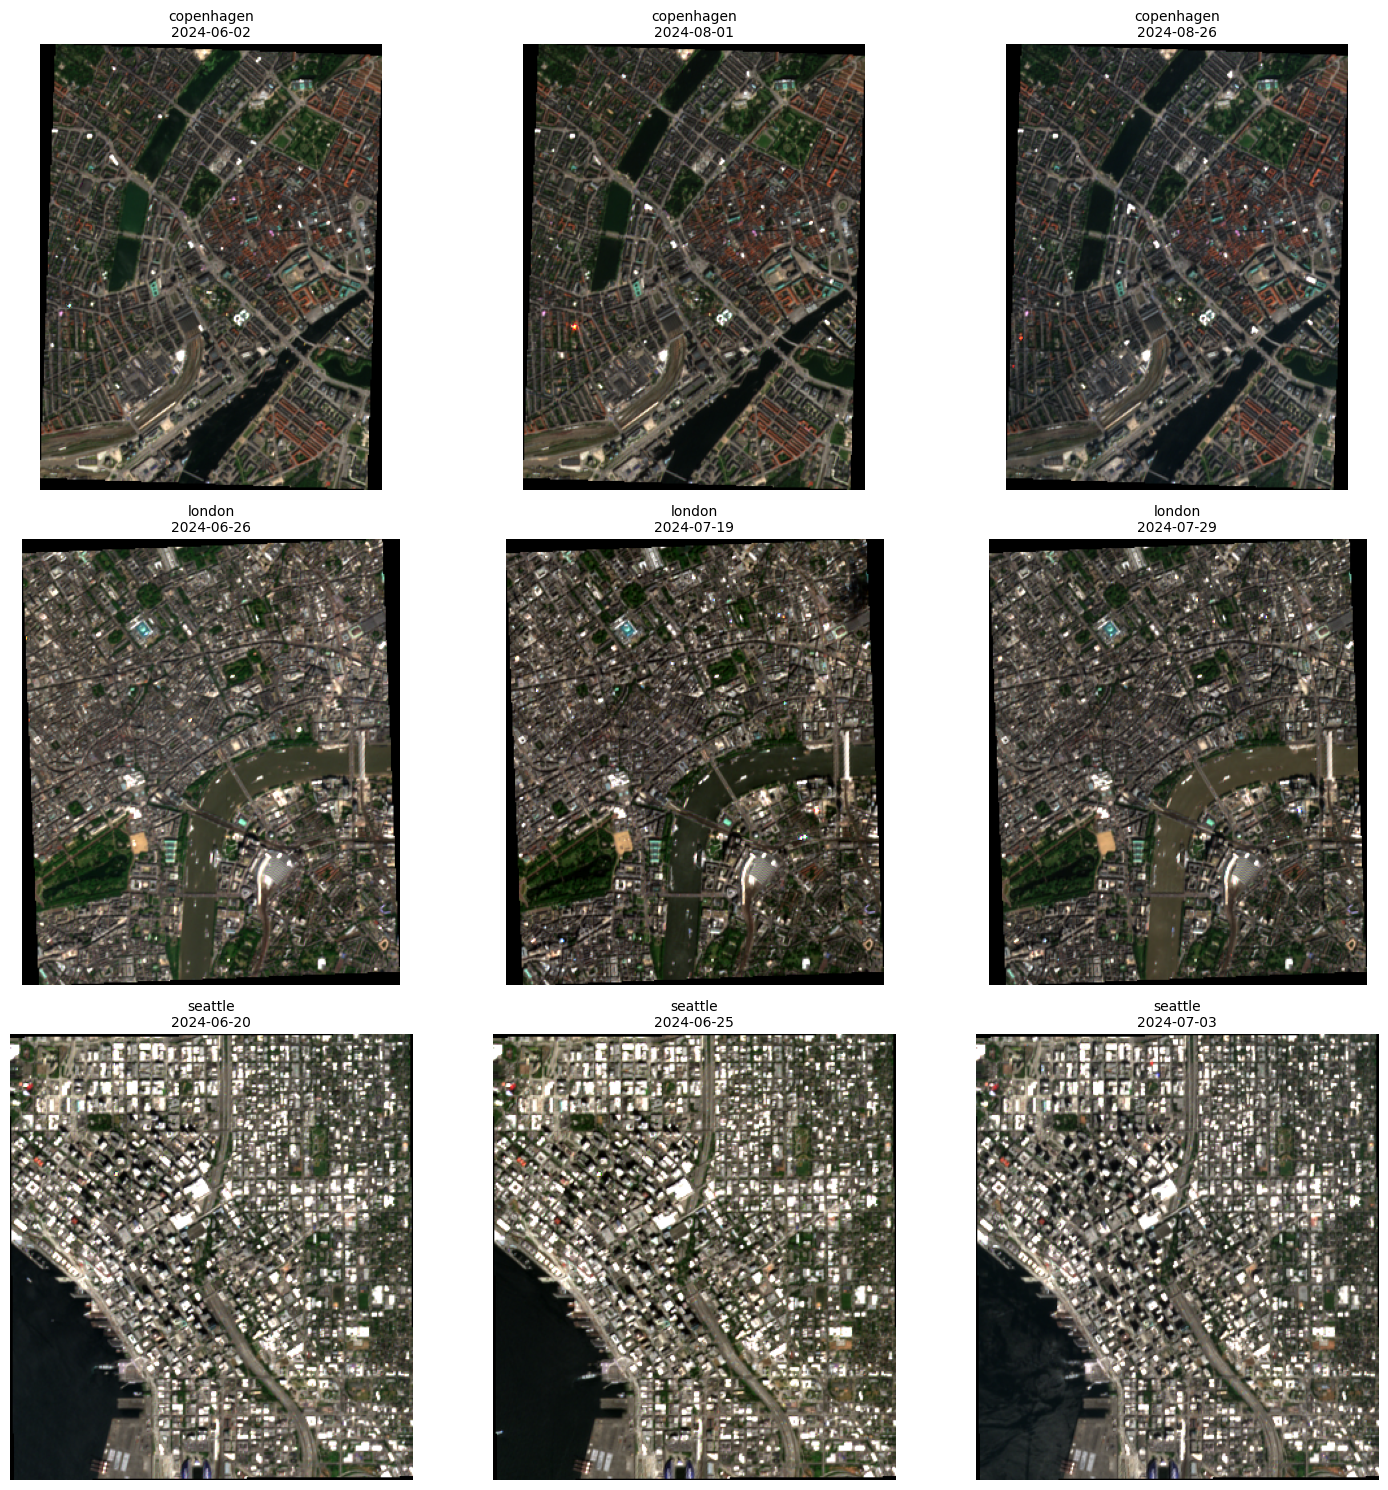


Visualization saved as: s2e84_multi_area_grid.png


In [14]:
# Create 3x3 grid (3 areas × 3 images per area)
rows = len(results)
cols = max_images_per_area

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# Handle single row case
if rows == 1:
    axes = axes.reshape(1, -1)

for area_idx, r in enumerate(results):
    area_name = r['area_name']
    dataset = r['dataset']
    n_images = r['n_images']
    
    # Show up to max_images_per_area
    n_display = min(n_images, max_images_per_area)
    
    for img_idx in range(cols):
        ax = axes[area_idx, img_idx]
        
        if img_idx < n_display:
            # Get image at this time step
            time_val = dataset.time.values[img_idx]
            image_slice = dataset.sel(time=time_val)
            date_str = str(time_val)[:10]
            
            # Process RGB for display
            rgb = process_rgb_for_display(image_slice)
            
            # Plot
            title = f"{area_name}\n{date_str}"
            plot_image(ax, rgb, title)
        else:
            # Empty subplot if not enough images
            ax.axis('off')

plt.tight_layout()
plt.savefig('s2e84_multi_area_grid.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved as: s2e84_multi_area_grid.png")

## Save Images to Disk (Optional)

Save all downloaded images as GeoTIFF files.

In [15]:
# Configure save parameters
save_params = SaveParams(
    output_path='../../data',
    save_to_local=True,
    save_as_geotiff=True,
)

# Save all images to disk
for r in results:
    area_name = r['area_name']
    dataset = r['dataset']
    
    print(f"\nSaving images for {area_name}...")
    
    for idx, time_val in enumerate(dataset.time.values):
        image_slice = dataset.sel(time=time_val)
        date_str = str(time_val)[:10]
        
        save_data(
            image=image_slice,
            identifier=area_name.lower(),
            datetime=date_str,
            satellite=processing_params.satellite,
            provider='E84',
            save_params=save_params,
            band='TCI',
        )
        
        print(f"  ✓ Saved: {area_name}_{date_str}")

print("\n✓ All images saved successfully!")


Saving images for copenhagen...
  ✓ Saved: copenhagen_2024-06-02
  ✓ Saved: copenhagen_2024-08-01
  ✓ Saved: copenhagen_2024-08-26

Saving images for london...
  ✓ Saved: london_2024-06-26
  ✓ Saved: london_2024-07-19
  ✓ Saved: london_2024-07-29
  ✓ Saved: london_2024-07-31
  ✓ Saved: london_2024-08-23

Saving images for seattle...
  ✓ Saved: seattle_2024-06-20
  ✓ Saved: seattle_2024-06-25
  ✓ Saved: seattle_2024-07-03
  ✓ Saved: seattle_2024-07-05
  ✓ Saved: seattle_2024-07-08
  ✓ Saved: seattle_2024-07-10
  ✓ Saved: seattle_2024-07-13
  ✓ Saved: seattle_2024-07-15
  ✓ Saved: seattle_2024-07-18
  ✓ Saved: seattle_2024-07-20
  ✓ Saved: seattle_2024-07-23
  ✓ Saved: seattle_2024-08-04
  ✓ Saved: seattle_2024-08-07
  ✓ Saved: seattle_2024-08-29

✓ All images saved successfully!
